编程题：

In [10]:
# todo 编程题: 在不使用sklearn的情况下，仅使用Numpy，为softmax回归实现带早停的批量梯度下降，将它用于分类任务，例如鸢尾花数据集

#  注意：
#  1. 要实现l2正则化
#  2. 除了数据读取，其他仅使用numpy，包括训练集+验证集分离，以及softmax预测 和 损失计算

In [11]:
import numpy as np
from sklearn.datasets import load_iris
from tensorflow.python.ops.math_ops import linspace

iris = load_iris(as_frame=True)

In [12]:
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [13]:
data = iris.data[['petal length (cm)' , 'petal width (cm)']].to_numpy()
data
data_label = iris.target.to_numpy().ravel()
data_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [30]:
import numpy as np
from copy import deepcopy
class SoftMaxClone():
    def __init__(self):
        self.w = None
        self.b = None

    def fit(self,X,y=None,*,lamda = .01 ,n_iter=10000,eta0 = .01 ,early_stopping = False , max_round =100 , random_state = None ,tol = 1.0e-5 ):
        self.eta0 = eta0
        self.n_iter_ = n_iter
        self.lamda = lamda
        self.n_iter = 0
        self.n_features = X.shape[1]
        self.early_stopping = early_stopping
        self.max_round = max_round
        self.best_score = np.inf
        self.best_w_b = None
        self.tol = tol
        # 函数要自己确认在测试集的分数，可以在函数内部将其分开训练开发集，训练集进行训练开发集进行过拟合验证
        if random_state is not None:
            np.random.seed(random_state)
        shuffle = np.random.permutation(X.shape[0],)
        train_idx = shuffle[:int(X.shape[0]*0.8//1)]
        test_idx = shuffle[int(X.shape[0]*0.8//1):]
        self.__X_train = X[train_idx,:]
        self.__X_test = X[test_idx,:]
        self.__y_train = y[train_idx]
        self.__y_test = y[test_idx]
        # 在类内实现的参数均被记录为类内属性，不需要再传入参数
        self.gradient_descent(self.__X_train,self.__y_train,) # n_iter=n_iter,eta0=self.eta0,early_stopping=self.early_stopping, max_round=self.max_round)
        return self

    def gradient_descent(self,X,y,): # *,n_iter=10000,eta0 = .01 ,early_stopping = False ,max_round = 10):

        # m = X.shape[0]
        n = X.shape[1]
        a = np.unique(y,)
        self.w = np.ones((n,len(a),))
        self.b = np.ones((len(a),))
        y_proba_ = y.reshape(-1,1).repeat(len(a),axis=1)
        y_proba = np.zeros_like(y_proba_)
        for k,v in enumerate(a):
            y_proba[y==v,k] =1

        self.history_loss = []
        k=0
        # 进行梯度下降
        for i in range(self.n_iter_):
            w_grad,b_grad = self.gradient_calculate(X,y_proba)
            loss = self.loss_function(X,y_proba,)
        # 实现梯度下降并更新权重与偏差
            self.w -=self.eta0 * w_grad
            self.w += 2*self.lamda * self.w/X.shape[0]
            self.b -=self.eta0 * b_grad
            self.b += 2*self.lamda * self.b/X.shape[0]

            self.history_loss.append(loss)

            self.n_iter +=1
            self.score =[]
            if self.early_stopping:
                # self.predict(self.__X_test)
                # score =
                # 早停标准：如果当前损失函数的与之前的损失函数的差值连续小于容忍度tol  max_round次那么就停止迭代并将版本回退到之前
                score = self.loss_function(X,y_proba)
                self.score.append(score)
                if self.best_score - score > self.tol :
                    self.best_score = score
                    self.best_w_b = deepcopy((self.w,self.b))
                    k = 0
                else:
                    if k < self.max_round:
                        k += 1
                    else:
                        self.w,self.b = self.best_w_b
                        self.n_iter -=self.max_round
                        break

    def loss_function(self,X,y ):   # ,lamda = .01):      #
        y_ = X @ self.w +  self.b           # X （m*2)  @ w (2*3)  b(3,)   -> y_ (m,3)
        exp_ = np.exp(y_ - np.max(y_,axis=1,keepdims=True))
        p_k_sum = np.sum(exp_,axis=1).reshape(-1,1)
        p_k = exp_/ p_k_sum          # p_k (m*3)
        l2 = self.lamda * np.sum(self.w**2) + self.lamda * np.sum(self.b**2)
        return (-np.sum(y*np.log(p_k+1.0e-10))    + l2)/X.shape[0]

    def gradient_calculate(self, X,y ):
        y_ = X@self.w +  self.b           # X （m*2)  @ w (2*3)  b(3,)   -> y_ (m,3)
        exp_ = np.exp(y_- np.max(y_,axis=1,keepdims=True))
        p_k_sum = np.sum(exp_,axis=1).reshape(-1,1)
        p_k = exp_/ p_k_sum          # p_k (m*3)

        pk_y = p_k - y
        pk_y_ = pk_y.repeat(self.w.shape[0],axis =1)
        X_ = np.tile(X,(1,self.w.shape[1]))

        grad = X_ * pk_y_
        w_grad = np.sum(grad , axis =0) / X.shape[0]
        return  w_grad.reshape(self.w.shape , order="F") ,np.sum(pk_y , axis = 0) / X.shape[0]

    def predict(self,X,y=None):
        res = self.predict_proba(X,y)
        return np.argmax(res,axis=1)

    def predict_proba(self,X,y=None):
        y_ = X @ self.w +  self.b           # X （m*2)  @ w (2*3)  b(3,)   -> y_ (m,3)
        exp_ = np.exp(y_ - np.max(y_,axis=1,keepdims=True))
        p_k_sum = np.sum(exp_,axis=1).reshape(-1,1)
        p_k = exp_/ p_k_sum          # p_k (m*3)
        return p_k

from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
data = iris.data[['petal length (cm)' , 'petal width (cm)']].to_numpy()

data_label = iris.target.to_numpy().ravel()

In [37]:
data_label = iris.target.to_numpy().ravel()
smx = SoftMaxClone()
np.random.seed(42)
shuffle = np.random.permutation(data.shape[0],)
train_idx = shuffle[:int(data.shape[0]*0.8//1)]
test_idx = shuffle[int(data.shape[0]*0.8//1):]
X_train = data[train_idx,:]
y_train =  data_label[train_idx]
X_test = data[test_idx,:]
y_test = data_label[test_idx]
smx.fit(X_train,y_train,lamda=.01,n_iter=10000,early_stopping =True,eta0 = .1,random_state = 42 ,max_round=1000,tol = 1.0e-9 )
print(smx.predict(X_train))
print(np.sum(y_train==smx.predict(X_train))/ len(y_train))
print(np.sum(smx.predict(X_test) == y_test) / len(y_test))
# print(smx.best_w_b)
print(smx.n_iter)
print(smx.score)
# print(smx.w)
# print(smx.b)

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 1 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2
 1 1 2 1 0 1 2 0 0 1 2 0 2 0 0 2 1 2 1 1 2 1 0 0 1 2 0 0 0 1 2 0 2 2 0 1 1
 2 1 2 0 2 1 2 1 1]
0.9583333333333334
0.9666666666666667
4200
[0.18282285974642734]


In [38]:
X_train

array([[4.7, 1.2],
       [1.7, 0.3],
       [6.9, 2.3],
       [4.5, 1.5],
       [4.8, 1.4],
       [1.5, 0.4],
       [3.6, 1.3],
       [5.1, 2.3],
       [4.5, 1.5],
       [3.9, 1.2],
       [5.1, 2. ],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.1],
       [1.5, 0.3],
       [4.7, 1.6],
       [5.8, 2.2],
       [3.9, 1.1],
       [4.5, 1.3],
       [5.6, 2.2],
       [1.6, 0.2],
       [4.9, 1.8],
       [1.6, 0.4],
       [5.6, 2.1],
       [6.4, 2. ],
       [5.2, 2.3],
       [5.8, 1.8],
       [5.9, 2.3],
       [1.4, 0.3],
       [1.6, 0.2],
       [1. , 0.2],
       [1.5, 0.4],
       [4.4, 1.4],
       [1.6, 0.2],
       [1.3, 0.2],
       [5. , 1.9],
       [4.5, 1.5],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [5.1, 1.9],
       [4.5, 1.6],
       [4.7, 1.5],
       [1.3, 0.4],
       [1.5, 0.2],
       [3.7, 1. ],
       [5.1, 1.5],
       [5.5, 1.8],
       [4.4, 1.4],
       [6.1, 2.5],
       [4.2, 1.3],
       [6.6, 2.1],
       [4.5,

In [39]:
X_test

array([[4.6, 1.4],
       [1.3, 0.3],
       [4.6, 1.3],
       [4.4, 1.2],
       [1.5, 0.2],
       [4.1, 1.3],
       [6.3, 1.8],
       [5.7, 2.1],
       [1.5, 0.4],
       [3.3, 1. ],
       [5.7, 2.5],
       [5.8, 1.6],
       [1.4, 0.1],
       [5.6, 2.4],
       [1.4, 0.2],
       [4.9, 1.5],
       [6.1, 1.9],
       [5.6, 1.8],
       [4.1, 1.3],
       [5.5, 1.8],
       [4.4, 1.3],
       [4.3, 1.3],
       [4.9, 2. ],
       [5.1, 1.8],
       [1.7, 0.2],
       [4. , 1.3],
       [4.5, 1.7],
       [1.2, 0.2],
       [4. , 1.2],
       [5.9, 2.1]])

In [40]:
y_train

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1])

In [41]:
y_test

array([1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 0, 1, 2, 0, 1, 2])

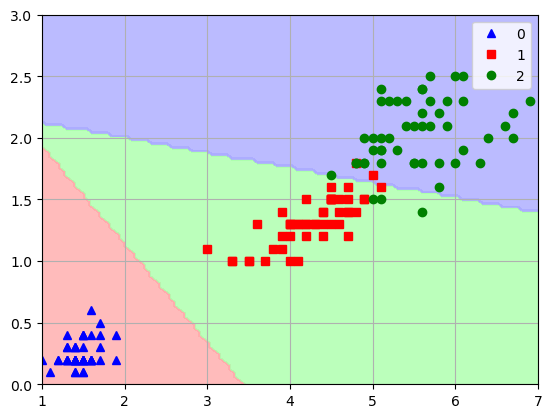

In [43]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

plt.plot(data[data_label==0][:,0],data[data_label==0][:,1] , 'b^' , label = '0')
plt.plot(data[data_label==1][:,0],data[data_label==1][:,1] , 'rs' , label = '1')
plt.plot(data[data_label==2][:,0],data[data_label==2][:,1] , 'go' , label = '2')
# w0 , w1 ,w2 = smx.best_w_b[0][:,0]  ,smx.best_w_b[0][:,1],smx.best_w_b[0][:,2]
# b0,b1,b2 = smx.best_w_b[1][0]  ,smx.best_w_b[1][1],smx.best_w_b[1][2]
x= np.linspace(1,7,100)
# w0 , w1 ,w2 = smx.w[:,0], smx.w[:,1], smx.w[:,2]
# b0,b1,b2 = smx.b[0], smx.b[1], smx.b[2]
# plt.plot(x,-(b0+w0[0]*x)/w0[1],'r-',label='line1')
# plt.plot(x,-(b1+w1[0]*x)/w1[1],'r-',label='line2')
# plt.plot(x,-(b2+w2[0]*x)/w2[1],'r-',label='line3')
xx,yy = np.meshgrid(np.linspace(1,7,100),np.linspace(0,3,100))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
n_features = data.shape[1]
grid_points = np.zeros((xx.ravel().shape[0], n_features))

# 绘制决策边界
xy = np.concatenate((xx.reshape(-1,1), yy.reshape(-1,1)), axis=1)
z = smx.predict(xy)
plt.contourf(xx, yy, z.reshape(100,100), cmap=cmap_light, alpha=0.8)
#
# plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.grid(True)
plt.legend()
plt.axis((1,7,0,3))
plt.show()


In [45]:
z.shape

(10000,)

b简答题：
1. 如果你的训练集具有数百万个特征，那么可以使用哪种线性回归训练算法？
随机梯度下降或者小批量梯度下降
2. 如果你的训练集里特征的数值大小迥异，那么哪些算法可能会受到影响？受影响程度如何？你应该怎么做？
梯度下降类的算法，k邻近值，支持向量机都会受到影响，数值大的特征会导致收敛速度慢，学习率不能设定太高，想要达到理想效果需要增加迭代次数，标准化一下
3. 训练逻辑回归模型时，梯度下降可能会卡在局部最小值中吗？
不会，逻辑回归的损失函数是凸函数
4. 如果你让它们运行足够长的时间，是否所有的梯度下降算法都能得出相同的模型？
不一定，批量梯度下降理论上是会到全局最小值，但是随机梯度下降和小批量梯度下降是会在最小值及其周围打转的
5. 假设你使用批量梯度下降，并在每个轮次绘制验证误差。如果你发现验证错误持续上升，那么可能是什么情况？你该如何解决？
可能是学习率过大导致的，此时可以调低学习率，也有可能是过拟合，正则化或者早停策略都可以解决
6. 当验证误差上升时立即停止小批量梯度下降是个好主意吗？
不是，有可能是正常的波动，最好经过多轮验证后在进行停止
7. 哪种梯度下降算法（在我们讨论过的算法中）将最快地到达最佳解附近？哪个实际上会收敛？如何使其他的也收敛
随机梯度下降最快（每次只迭代一个样本），批量梯度下降会收敛，采用学习率衰减策略
8. 假设你正在使用多项式回归。绘制学习曲线后，你会发现训练误差和验证误差之间存在很大的差距。发生了什么？解决此问题的三种方法是什么？
过拟合，增加训练数据，正则化，降低degree
9. 假设你正在使用岭回归，并且你注意到训练误差和验证误差几乎相等且相当高。你是否会说模型存在高偏差或高方差？你应该增加正则化超参数α还是减小它呢？
是高偏差也就是欠拟合，减小正则化参数$\alpha$
10. 为什么要使用：a.岭回归而不是简单的线性回归（即没有任何正则化）？b.Lasso而不是岭回归？c.弹性网络而不是Lasso回归？
a.对于大部分样本而言普通的线性回归和可能造成欠拟合，岭回归可以通过l2正则化提高泛化能力
b.lasso使用的是l1正则化，它在正则化的途中会将低权重的特征不断压缩，最后归0，当特征很多时可以选择lasso
c.弹性网络既有l1正则化的特征选择，又可以处理共线问题
11. 假设你要将图片分类为室外/室内和白天/夜间。你应该实现两个逻辑回归分类器还是一个softmax回归分类器？
两个逻辑回归分类器，softmax适用于互斥的多分类问题，而问题上是多标签多分类问题
